# Image Classification w/ Caffe Model
This tutorial demonstrates the steps required to prepare and deploy a trained Caffe model for FPGA acceleration  
We will prepare a trained Inception v1 model, and then run a single inference.  

# Model Preparation (Offline Process, Performed Once):

## Phase 1: Compile The Model  
    * A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
    * The network is optimized
    * FPGA Instructions are generated
      * These instructions are required to run the network in "one-shot", and minimize data movement

## Phase 2: Quantize The Model
    * The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT16 or INT8
    * This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve faster inference
      * While floating point precision is useful in the model training scenario
          It is not required for high speed, high accuracy inference
    
# Model Deployment (Online Process, Typically Performed Iteratively):  
    
## Phase 3: Deploy The Model
Once you have the outputs of the compiler and quantizer, you will use the xfDNN deployment APIs to:
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run fully connected layers on the CPU
7. Run Softmax on CPU
8. Print the result (or send the result for further processing)
9. When you are done, close the handle to the FPGA

First, we will look at compiling, quantizing and deploying a Inception v1 image classification example. After completing the example, we will look at deploying a custom model, using the same steps. 

### Step 1. Import required packages, check environment.

In [1]:
import os,sys,cv2
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

# Bring in Xilinx ML-Suite Compiler, Quantizer, PyXDNN
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe import CaffeFrontend as xfdnnCompiler
from xfdnn.tools.quantize.quantize import CaffeFrontend as xfdnnQuantizer
import xfdnn.rt.xdnn as pyxfdnn
import xfdnn.rt.xdnn_io as pyxfdnn_io

import warnings
warnings.simplefilter("ignore", UserWarning)

print("Current working directory: %s" % os.getcwd())
print("Running on host: %s" % os.uname()[1])
print("Running w/ LD_LIBRARY_PATH: %s" %  os.environ["LD_LIBRARY_PATH"])
print("Running w/ XILINX_OPENCL: %s" %  os.environ["XILINX_OPENCL"])
print("Running w/ XCLBIN_PATH: %s" %  os.environ["XCLBIN_PATH"])
print("Running w/ PYTHONPATH: %s" %  os.environ["PYTHONPATH"])
print("Running w/ SDACCEL_INI_PATH: %s" %  os.environ["SDACCEL_INI_PATH"])

!whoami # Must run as root if running on AWS EC2 F1, just check who you are below

# Make sure there is no error in this cell
# The xfDNN runtime depends upon the above environment variables

Current working directory: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/notebooks
Running on host: xsjmanasab4-vcu1525
Running w/ LD_LIBRARY_PATH: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/overlaybins/1525/runtime/lib/x86_64/:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/rt/xdnn_cpp/build/lib:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/rt/lib:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/ext/boost/lib:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/notebooks
Running w/ XILINX_OPENCL: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/overlaybins/1525
Running w/ XCLBIN_PATH: /home/bryanloz/DEEPXILINX/FRESH/MLsuite/overlaybins/1525
Running w/ PYTHONPATH: /home/bryanloz/DEEPXILINX/FRESH/MLsuite:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/apps/yolo:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/apps/yolo/nms:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/rt:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/tools/emu:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/tools/compile/network:/home/bryanloz/DEEPXILINX/FRESH/MLsuite/xfdnn/tools/

### Step 2. Use a config dictionary to pass parameters.

Here, we will setup and use a config dictionary to simplify handling of the arguments. In this cell, we will also perform some basic error checking. For this first example, we will attempt to classify a picture of a dog. 


Runnning on VCU1525


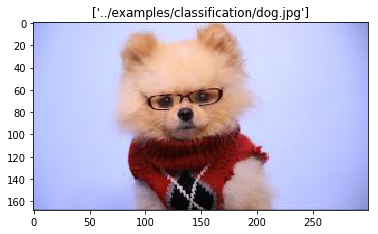

In [2]:
config = {}

# Quick check to see if we are running on AWS, if not assume 1525 box
if os.path.exists("/sys/hypervisor/uuid"):
    with open("/sys/hypervisor/uuid") as fp:
        contents = fp.read()
        if "ec2" in contents:
            print("Runnning on Amazon AWS EC2")
            config["device"] = "aws"
else:
    print("Runnning on VCU1525")
    config["device"] = "1525"


config["images"] = ["../examples/classification/dog.jpg"] # Image of interest (Must provide as a list)

img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(config["images"])
plt.show()

### Step 3. Define an xfdnnCompiler instance and pass it arguments.  
To simplify handling of arguments, we continue to use a config dictionary. Take a look at the dictionary entries below. 

The arguments that need to be passed are: 
- `prototxt` - Caffe representation of the network
- `caffemodel` - Pre-trained Model for the network 
- `outmodel` - Filename for saving the prototxt and caffemodel of the optimized network
- `fpgacommands` - Filename to save micro-instruction produced by the compiler needed to deploy
- `memory` - Parameter to set the on-chip memory for the target xDNN overlay. This example will target an overlay with 5 MB of cache. 
- `dsp` - Parameter to set the size of the target xDNN overlay. This example uses an overlay of size 32x56 DSPs. 

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////  
Memory, and DSP are critical arguments that correspond to the hardware accelerator you plan to load onto the FPGA.  
The memory, and dsp parameters can be extracted from the name of the fpga programming file "xclbin".  
Don't worry about this detail for now. Just know that if you change the xclbin, you have to recheck these parameters.  
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////  

The xfDNN Compiler interfaces with Caffe to read a network graph, and generates a sequence of instructions for the xfDNN Deploy APIs to execute on the FPGA.  

During this process the xfDNN Compiler performs computational graph traversal, node merging and optimization, memory allocation and optimization and, finally, micro-instruction generation.
  

In [3]:
# Compiler Arguments

config["prototxt"] = "../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_deploy.prototxt" 
config["caffemodel"] = "../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn.caffemodel"
config["outmodel"] = "work/optimized_model" # String for naming optimized prototxt, caffemodel
config["fpgacommands"] = "work/fpga.cmds" # Compiler will generate FPGA instructions
config["memory"] = 5 # Available on-chip SRAM
config["dsp"] = 56 # Width of Systolic Array

compiler = xfdnnCompiler(
    networkfile=config["prototxt"],       # Prototxt filename: input file
    weights=config["caffemodel"],         # Floating Point Weights: input file
    anew=config["outmodel"],              # String for intermediate prototxt/caffemodel
    generatefile=config["fpgacommands"],  # Script filename: output file
    memory=config["memory"],              # Available on chip SRAM within xclbin
    dsp=config["dsp"]                     # Rows in DSP systolic array within xclbin
)

# Invoke compiler
try:
    compiler.compile()

    # The compiler extracts the floating point weights from the .caffemodel. 
    # This weights dir will be stored in the work dir with the appendex '_data'. 
    # The compiler will name it after the caffemodel, and append _data
    config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data"
        
    if os.path.exists(config["datadir"]) and os.path.exists(config["fpgacommands"]+".json"):
        print("Compiler successfully generated JSON and the data directory: %s" % config["datadir"])
    else:
        print("Compiler failed to generate the JSON or data directory: %s" % config["datadir"])
        raise
        
    print("**********\nCompilation Successful!\n")
    
    import json
    data = json.loads(open(config["fpgacommands"]+".json").read())
    print("Network Operations Count: %d"%data['ops'])
    print("DDR Transfers (bytes): %d"%data['moveops']) 
    
except Exception as e:
    print("Failed to complete compilation:",e)


Network: ../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn_deploy.prototxt
GenerateCode: work/fpga.cmds
Weights: ../models/caffe/bvlc_googlenet_without_lrn/fp32/bvlc_googlenet_without_lrn.caffemodel
PngFile: None
ConcatStrategy: None
Strategy: all
ScheduleFile: None
DSP: 56
Verbose: False
FromTF: False
Memory: 5
DDR: 256
Phase: TEST
RankDir: BT

**************************************************
* BUILDING DATA FLOW GRAPH
**************************************************

**************************************************
* BUILDING NETWORK SCHEDULE
**************************************************
Network Schedule ['data', 'conv1/7x7_s2', 'conv1/relu_7x7', 'pool1/3x3_s2', 'conv2/3x3_reduce', 'conv2/relu_3x3_reduce', 'conv2/3x3', 'conv2/relu_3x3', 'pool2/3x3_s2', 'inception_3a/1x1', 'inception_3a/relu_1x1', 'inception_3a/3x3_reduce', 'inception_3a/relu_3x3_reduce', 'inception_3a/3x3', 'inception_3a/relu_3x3', 'inception_3a/5x5_reduce', 'inception_3a/relu_5x5_

Compiler successfully generated JSON and the data directory: work/bvlc_googlenet_without_lrn.caffemodel_data
**********
Compilation Successful!

Network Operations Count: 3176103168
DDR Transfers (bytes): 0


### Step 4. Create Quantizer Instance and run it.

To simplify handling of arguments, a config dictionary is used. Take a look at the dictionary below.

The arguments that need to be passed are:
- `deploy_model` - Filename generated by the compiler for the optimized prototxt and caffemodel.
- `quantizecfg` - Output JSON filename of quantization scaling parameters. 
- `bitwidths` - Desired precision from quantizer. This is to set the precision for [image data, weight bitwidth, conv output]. All three values need to be set to the same setting. The valid options are `16` for Int16 and `8` for Int8.  
- `in_shape` - Sets the desired input image size of the first layer. Images will be resized to these demensions and must match the network data/placeholder layer.
- `transpose` - Images start as H,W,C (H=0,W=1,C=2) transpose swaps to C,H,W (2,0,1) for typical networks.
- `channel_swap` - Depending on network training and image read, can swap from RGB (R=0,G=1,B=2) to BGR (2,1,0).
- `raw_scale` - Depending on network training, scale pixel values before mean subtraction.
- `img_mean` - Depending on network training, subtract image mean if available.
- `input_scale` - Depending on network training, scale after subtracting mean.
- `calibration_size` - Number of images the quantizer will use to calculate the dynamic range. 
- `calibration_directory` - Location of dir of images used for the calibration process. 

Below is an example with all the parameters filled in. `channel_swap` `raw_scale` `img_mean` `input_scale` are image preprocessing arguments specific to a given model.

In [4]:
# Use a config dictionary to pass parameters to the compiler
# Quantizer Arguments
#config["outmodel"] = Defined in Step 1 # String for naming intermediate prototxt, caffemodel
config["quantizecfg"] = "work/quantization_params.json" # Quantizer will generate quantization params
config["bitwidths"] = [16,16,16] # Supported quantization precision
config["in_shape"] = [3,224,224] # Images will be resized to this shape -> Needs to match prototxt
config["transpose"] = [2,0,1] # (H,W,C)->(C,H,W) transpose argument to quantizer
config["channel_swap"] = [2,1,0] # (R,G,B)->(B,G,R) Channel Swap argument to quantizer
config["raw_scale"] = 255.0 # Raw scale of input pixels, i.e. 0 <-> 255
config["img_mean"] = [104.007, 116.669, 122.679] # Mean of the training set used for mean subtraction
config["input_scale"] = 1.0 # Input multiplier, Images are scaled by this factor after mean subtraction
config["calibration_size"] = 15 # Number of calibration images quantizer will use
config["calibration_directory"] = "../xfdnn/tools/quantize/calibration_directory" # Directory of images

quantizer = xfdnnQuantizer(
    deploy_model=config["outmodel"]+".prototxt",        # Model filename: input file
    weights=config["outmodel"]+".caffemodel",           # Floating Point weights
    output_json=config["quantizecfg"],                    # Quantization JSON output filename
    bitwidths=config["bitwidths"],                        # Fixed Point precision: 8,8,8 or 16,16,16
    dims=config["in_shape"],                              # Image dimensions [C,H,W]
    transpose=config["transpose"],                        # Transpose argument to caffe transformer
    channel_swap=config["channel_swap"],                  # Channel swap argument to caffe transfomer
    raw_scale=config["raw_scale"],                        # Raw scale argument to caffe transformer
    mean_value=config["img_mean"],                        # Image mean per channel to caffe transformer
    input_scale=config["input_scale"],                    # Input scale argument to caffe transformer
    calibration_size=config["calibration_size"],          # Number of calibration images to use
    calibration_directory=config["calibration_directory"] # Directory containing calbration images
)

# Invoke quantizer
try:
    quantizer.quantize()

    import json
    data = json.loads(open(config["quantizecfg"]).read())
    print("**********\nSuccessfully produced quantization JSON file for %d layers.\n"%len(data['network']))
except Exception as e:
    print("Failed to quantize:",e)

Mean : [104.007 116.669 122.679]
Adding ../xfdnn/tools/quantize/calibration_directory/13923040300_b4c8521b4d_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/14931486720_37bd588ce9_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/15439525724_97d7cc2c81_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/16247716843_b419e8b111_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/3272651417_27976a64b3_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/3591612840_33710806df_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/36085792773_b9a3d115a3_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/4788821373_441cd29c9f_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/calibration_directory/4814953542_de4b973dc2_z.jpg to calibration batch.
Adding ../xfdnn/tools/quantize/cali

Min:  0 , Max:  2692.7102
n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  2692.710205078125 , sf_layer_out:  0.0821775019097911
Threshold out shape= ()
Min:  0 , Max:  2692.7102
n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  2692.710205078125 , sf_layer_out:  0.0821775019097911
bw_layer_in:  16
th_layer_in:  2234.35498046875
bw_layer_out:  16
th_layer_out:  2692.710205078125
--------------------------------------------------------------------------------
Processing layer 15 of 149
Layer Name:inception_3a/3x3_relu Type:ReLU
Inputs: ['inception_3a/3x3'], Outputs: ['inception_3a/3x3']
Min:  0 , Max:  2375.6267
n:  32768 , len(bin_edges):  1228
Mean : th_layer_out:  2375.626708984375 , sf_layer_out:  0.07250058622957167
bw_layer_out:  16
th_layer_out:  2375.626708984375
--------------------------------------------------------------------------------
Processing layer 16 of 149
Layer Name:inception_3a/5x5_reduce Type:Convolution
Inputs: ['pool2/3x3_s2_pool2/3x3_s2_0_split_2'

Min:  0 , Max:  1354.4025
n:  32768 , len(bin_edges):  1504
Mean : th_layer_out:  1354.4024658203125 , sf_layer_out:  0.04133434448745117
Threshold out shape= ()
Min:  0 , Max:  1354.4025
n:  32768 , len(bin_edges):  1504
Mean : th_layer_out:  1354.4024658203125 , sf_layer_out:  0.04133434448745117
bw_layer_in:  16
th_layer_in:  1430.228515625
bw_layer_out:  16
th_layer_out:  1354.4024658203125
--------------------------------------------------------------------------------
Processing layer 30 of 149
Layer Name:inception_3b/3x3_relu Type:ReLU
Inputs: ['inception_3b/3x3'], Outputs: ['inception_3b/3x3']
Min:  0 , Max:  1155.4857
n:  32768 , len(bin_edges):  1504
Mean : th_layer_out:  1155.4857177734375 , sf_layer_out:  0.03526370182724807
bw_layer_out:  16
th_layer_out:  1155.4857177734375
--------------------------------------------------------------------------------
Processing layer 31 of 149
Layer Name:inception_3b/5x5_reduce Type:Convolution
Inputs: ['inception_3a/output_inception_3

Min:  0 , Max:  1309.7566
n:  32768 , len(bin_edges):  533
Mean : th_layer_out:  1309.756591796875 , sf_layer_out:  0.03997181895800272
bw_layer_out:  16
th_layer_out:  1309.756591796875
--------------------------------------------------------------------------------
Processing layer 45 of 149
Layer Name:inception_4a/3x3 Type:Convolution
Inputs: ['inception_4a/3x3_reduce'], Outputs: ['inception_4a/3x3']
Quantizing conv input layer ... inception_4a/3x3
Threshold in shape= ()
Quantizing conv weights for layer inception_4a/3x3...
Threshold params shape= (208,)
Min:  0 , Max:  1173.4298
n:  32768 , len(bin_edges):  783
Mean : th_layer_out:  1173.4298095703125 , sf_layer_out:  0.03581132876278916
Threshold out shape= ()
Min:  0 , Max:  1173.4298
n:  32768 , len(bin_edges):  783
Mean : th_layer_out:  1173.4298095703125 , sf_layer_out:  0.03581132876278916
bw_layer_in:  16
th_layer_in:  1309.756591796875
bw_layer_out:  16
th_layer_out:  1173.4298095703125
-------------------------------------

n:  32768 , len(bin_edges):  813
Mean : th_layer_out:  400.1512451171875 , sf_layer_out:  0.012212019565940962
bw_layer_in:  16
th_layer_in:  578.734619140625
bw_layer_out:  16
th_layer_out:  400.1512451171875
--------------------------------------------------------------------------------
Processing layer 61 of 149
Layer Name:inception_4b/3x3_relu Type:ReLU
Inputs: ['inception_4b/3x3'], Outputs: ['inception_4b/3x3']
Min:  0 , Max:  400.15125
n:  32768 , len(bin_edges):  813
Mean : th_layer_out:  400.1512451171875 , sf_layer_out:  0.012212019565940962
bw_layer_out:  16
th_layer_out:  400.1512451171875
--------------------------------------------------------------------------------
Processing layer 62 of 149
Layer Name:inception_4b/5x5_reduce Type:Convolution
Inputs: ['inception_4a/output_inception_4a/output_0_split_2'], Outputs: ['inception_4b/5x5_reduce']
Quantizing conv input layer ... inception_4b/5x5_reduce
Threshold in shape= ()
Quantizing conv weights for layer inception_4b/5x5_r

Min:  0 , Max:  235.29738
n:  32768 , len(bin_edges):  869
Mean : th_layer_out:  235.29737854003906 , sf_layer_out:  0.007180925276651481
Threshold out shape= ()
Min:  0 , Max:  235.29738
n:  32768 , len(bin_edges):  869
Mean : th_layer_out:  235.29737854003906 , sf_layer_out:  0.007180925276651481
bw_layer_in:  16
th_layer_in:  365.8129577636719
bw_layer_out:  16
th_layer_out:  235.29737854003906
--------------------------------------------------------------------------------
Processing layer 76 of 149
Layer Name:inception_4c/3x3_relu Type:ReLU
Inputs: ['inception_4c/3x3'], Outputs: ['inception_4c/3x3']
Min:  0 , Max:  235.29738
n:  32768 , len(bin_edges):  869
Mean : th_layer_out:  235.29737854003906 , sf_layer_out:  0.007180925276651481
bw_layer_out:  16
th_layer_out:  235.29737854003906
--------------------------------------------------------------------------------
Processing layer 77 of 149
Layer Name:inception_4c/5x5_reduce Type:Convolution
Inputs: ['inception_4b/output_inceptio

n:  32768 , len(bin_edges):  922
Mean : th_layer_out:  297.9419860839844 , sf_layer_out:  0.0090927453256015
Threshold out shape= ()
Min:  0 , Max:  297.942
n:  32768 , len(bin_edges):  922
Mean : th_layer_out:  297.9419860839844 , sf_layer_out:  0.0090927453256015
bw_layer_in:  16
th_layer_in:  317.74530029296875
bw_layer_out:  16
th_layer_out:  297.9419860839844
--------------------------------------------------------------------------------
Processing layer 91 of 149
Layer Name:inception_4d/3x3_relu Type:ReLU
Inputs: ['inception_4d/3x3'], Outputs: ['inception_4d/3x3']
Min:  0 , Max:  260.75366
n:  32768 , len(bin_edges):  922
Mean : th_layer_out:  260.753662109375 , sf_layer_out:  0.00795781310798593
bw_layer_out:  16
th_layer_out:  260.753662109375
--------------------------------------------------------------------------------
Processing layer 92 of 149
Layer Name:inception_4d/5x5_reduce Type:Convolution
Inputs: ['inception_4c/output_inception_4c/output_0_split_2'], Outputs: ['inc

bw_layer_out:  16
th_layer_out:  110.70768737792969
--------------------------------------------------------------------------------
Processing layer 105 of 149
Layer Name:inception_4e/3x3 Type:Convolution
Inputs: ['inception_4e/3x3_reduce'], Outputs: ['inception_4e/3x3']
Quantizing conv input layer ... inception_4e/3x3
Threshold in shape= ()
Quantizing conv weights for layer inception_4e/3x3...
Threshold params shape= (320,)
Min:  0 , Max:  102.01954
n:  32768 , len(bin_edges):  971
Mean : th_layer_out:  102.01953887939453 , sf_layer_out:  0.003113484264027666
Threshold out shape= ()
Min:  0 , Max:  102.01954
n:  32768 , len(bin_edges):  971
Mean : th_layer_out:  102.01953887939453 , sf_layer_out:  0.003113484264027666
bw_layer_in:  16
th_layer_in:  110.70768737792969
bw_layer_out:  16
th_layer_out:  102.01953887939453
--------------------------------------------------------------------------------
Processing layer 106 of 149
Layer Name:inception_4e/3x3_relu Type:ReLU
Inputs: ['incept

n:  32768 , len(bin_edges):  155
Mean : th_layer_out:  147.24923706054688 , sf_layer_out:  0.0044938272365656565
Threshold out shape= ()
Min:  0 , Max:  147.24924
n:  32768 , len(bin_edges):  155
Mean : th_layer_out:  147.24923706054688 , sf_layer_out:  0.0044938272365656565
bw_layer_in:  16
th_layer_in:  171.35264587402344
bw_layer_out:  16
th_layer_out:  147.24923706054688
--------------------------------------------------------------------------------
Processing layer 124 of 149
Layer Name:inception_5a/5x5_reduce_relu Type:ReLU
Inputs: ['inception_5a/5x5_reduce'], Outputs: ['inception_5a/5x5_reduce']
Min:  0 , Max:  147.24924
n:  32768 , len(bin_edges):  155
Mean : th_layer_out:  147.24923706054688 , sf_layer_out:  0.0044938272365656565
bw_layer_out:  16
th_layer_out:  147.24923706054688
--------------------------------------------------------------------------------
Processing layer 125 of 149
Layer Name:inception_5a/5x5 Type:Convolution
Inputs: ['inception_5a/5x5_reduce'], Outputs

Min:  0 , Max:  67.099106
n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  67.09910583496094 , sf_layer_out:  0.0020477646972551938
Threshold out shape= ()
Min:  0 , Max:  67.099106
n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  67.09910583496094 , sf_layer_out:  0.0020477646972551938
bw_layer_in:  16
th_layer_in:  69.3115234375
bw_layer_out:  16
th_layer_out:  67.09910583496094
--------------------------------------------------------------------------------
Processing layer 141 of 149
Layer Name:inception_5b/5x5_relu Type:ReLU
Inputs: ['inception_5b/5x5'], Outputs: ['inception_5b/5x5']
Min:  0 , Max:  43.982273
n:  32768 , len(bin_edges):  308
Mean : th_layer_out:  43.98227310180664 , sf_layer_out:  0.0013422734184333823
bw_layer_out:  16
th_layer_out:  43.98227310180664
--------------------------------------------------------------------------------
Processing layer 142 of 149
Layer Name:inception_5b/pool Type:Pooling
Inputs: ['inception_5a/output_inception_5a/output_0_

## Phase 3. Deploy The Model.
Next, we need to utilize the xfDNN APIs to deploy our network to the FPGA. We will walk through the deployment APIs, step by step: 
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run fully connected layers on the CPU
7. Run Softmax on CPU
8. Print the result (or send the result for further processing)
9. When you are done, close the handle to the FPGA

First, we will create the handle to communicate with the FPGA and choose which FPGA overlay to run the inference on. For this lab, we will use the `xdnn_v2_32x56_2pe_16b_6mb_bank21` overlay. You can learn about other overlay options in the ML Suite Tutorials [here][].  

[here]: https://github.com/Xilinx/ml-suite
        
### Step 5. Open a handle for FPGA communication.

In [5]:
# Create a handle with which to communicate to the FPGA
# The actual handle is managed by pyxfdnn

config["xclbin"] = "../overlaybins/" + config["device"] + "/xdnn_v2_32x56_2pe_16b_6mb_bank21.xclbin" # Chosen Hardware Overlay
## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
## Specifically, the DSP array width, and the memory arguments

config["xfdnn_library"] = "../xfdnn/rt/xdnn_cpp/lib/libxfdnn.so" # Library functions called by pyXFDNN

ret = pyxfdnn.createHandle(config['xclbin'], "kernelSxdnn_0", config['xfdnn_library'])
if ret:                                                             
    print("ERROR: Unable to create handle to FPGA")
else:
    print("INFO: Successfully created handle to FPGA")
    
# If this step fails, most likely the FPGA is locked by another user, or there is some setup problem with the hardware
# For instance the xclbin could have been built for the wrong DSA/shell

INFO: Successfully created handle to FPGA


### Step 6. Apply quantization scaling and transfer model weights to the FPGA. 

In [6]:
# Quantize, and transfer the weights to FPGA DDR

# config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data" # From Compiler
config["scaleA"] = 10000 # Global scaler for weights (Must be defined, although not used)
config["scaleB"] = 30 # Global scaler for bias (Must be defined, although not used)
config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements

(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)

# Note that this function returns pointers to weights corresponding to the layers that will be implemented in the CPU

Loading weights/bias/quant_params to FPGA...


### Step 7. Allocate space in host memory for inputs, load images from disk, and prepare images. 

In [7]:
# Allocate space in host memory for inputs, Load images from disk

config["transform"] = "resize" # Resize Images to fit into network
config["firstfpgalayer"] = "conv1/7x7_s2" # Name of first layer to be ran on the FPGA -> Needs to match prototxt

(fpgaInputs, batch_sz) = pyxfdnn_io.prepareInput(config)

### Step 8. Allocate space in host memory for outputs.

In [8]:
# Allocate space in host memory for outputs

config["fpgaoutsz"] = 1024 # Number of elements in the activation of the last layer ran on the FPGA

fpgaOutputs = pyxfdnn_io.prepareOutput(config['fpgaoutsz'], batch_sz)

### Step 9. Write optimized micro-code to the xDNN Processing Engine on the FPGA. 

In [9]:
# Write FPGA Instructions to FPGA and Execute the network!
if len(pyxfdnn._xdnnManager._handles) > 0: # Just make sure FPGA still available
    pyxfdnn.execute(
        config["fpgacommands"],
        weightsBlob,
        fpgaInputs,
        fpgaOutputs,
        batch_sz, # Number of images we are processing
        config['quantizecfg'], 
        config['scaleB'], 
        config['PE']
    )

### Step 10. Execute the Fully Connected Layers on the CPU.

In [10]:
config["outsz"] = 1000 # Number of elements output by FC layers
config["useblas"] = True # Accelerate Fully Connected Layers in the CPU

if len(pyxfdnn._xdnnManager._handles) > 0: # Just make sure FPGA still available
    fcOut = pyxfdnn.computeFC(
        fcWeight, 
        fcBias, 
        fpgaOutputs,
        batch_sz, 
        config['outsz'], 
        config['fpgaoutsz'], 
        config['useblas'] # Can use cblas if True or numpy if False
    )

### Step 11. Execute the Softmax layers.

In [11]:
# Compute the softmax to convert the output to a vector of probabilities
softmaxOut = pyxfdnn.computeSoftmax(fcOut, batch_sz)

### Step 12. Output the classification prediction scores.



---------- Prediction 0 for ../examples/classification/dog.jpg ----------
0.6939 - "n02112018 Pomeranian"
0.0782 - "n02123394 Persian cat"
0.0496 - "n02085620 Chihuahua"
0.0188 - "n04399382 teddy, teddy bear"
0.0186 - "n02094433 Yorkshire terrier"



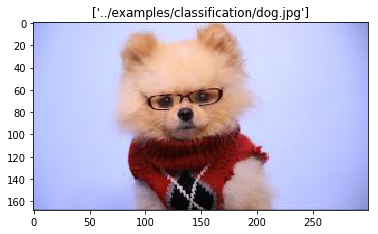

In [12]:
# Print the classification given the labels synset_words.txt (Imagenet classes)

config["labels"] = "../examples/classification/synset_words.txt"
pyxfdnn_io.printClassification(softmaxOut, config);

#Print Original Image for Reference 
img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(config["images"])
plt.show()

### Step 13. Close the handle.

In [13]:
pyxfdnn.closeHandle()

### Step 14. Your Turn! 
Great work! Now it is your turn! 

We have another trained model which leverages the Inception v1 architecture.    
This one is trained on the flowers dataset which has 102 classes.  

The final, fully connected layer has only 102 outputs for 102 output categories.  

This means that the graph and weights are different.

Update this notebook to classify pretty flowers instead!

Start by clicking **Kernel** from the menu, and then select **Reset & Clear Output**. 

Next update the parameters in the following steps:   

### In Step 2:
Set `config["images"]` to a new image.  A test flower image is located here: `"../examples/classification/flower.jpg"`

### In Step 3:
Set `config["prototxt"]` to a new network: To classify flowers, use the prototxt located here: `"../models/caffe/flowers102/fp32/bvlc_googlenet_without_lrn_deploy.prototxt"`   

Set `config["caffemodel"]` to a model trained to classify flowers. The flowers caffe model is located here: `"../models/caffe/flowers102/fp32/bvlc_googlenet_without_lrn.caffemodel"`

### In Step 10:
Set `config["outsz"]` to reflect the number of classification categories for flowers, which is `102`.  

### In Step 12:
Set `config["labels"]` with the flower labels. The labels are located here: `"../models/caffe/flowers102/data/synset_words.txt"`  

When you have made all the updates, click **Kernel** from the menu, and select **Restart & Run All** to see if you can classify the flower! 